# You'll learn

## ML methods

- Deep NN with keras

Course [slides](https://github.com/leggerf/MLCourse-2021/blob/master/Slides/Day3/Big%20data%20science%20-%20Day%203%20-%202021.pdf)

In [1]:
%reload_ext custom_magics

#ignore warnings from Tensorflow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
import tensorflow as tf
if type(tf.contrib) != type(tf): tf.contrib._warning = None
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.feature import VectorAssembler

#import Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(1337)  # for reproducibility

# Check out these custom functions
from custom_functions import *

In [2]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-leggerf>

Keras training is not distributed, therefore you cannot feed the largest data sample (10M) or python will go out of memory! This is already a big limitation.  

Still we need spark to be able to read in the input data from HDFS

In [3]:
# read in input data

#inputFile = 'hdfs://192.168.2.39/data/Higgs100k.parquet'
inputFile = 'hdfs://192.168.2.39/data/Higgs1M.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet' # too large, doesn't fit in memory

df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

There are 979519 events


In [4]:
#df.show()
X, y, X_test, y_test = prepareData(df, 0.2)

print('Events for training '+str(len(y)))
print('Events for validation '+str(len(y_test)))

Events for training 784282
Events for validation 195237


In [5]:
# When you're done, stop spark
spark.stop()

# Exercise 1

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [6]:
# now let's first look at NN in keras

# create the model
model = Sequential()

#baseline, 13m with 1M events, acc 74%, AUC 81
model.add(Dense(100, activation='relu', input_shape=(28,)))
model.add(Dense(1, activation='sigmoid'))
opt = Adam()

# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [7]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [8]:
%%time
history = model.fit(X, y, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[es]) #, verbose=0)

Train on 784282 samples, validate on 195237 samples
Epoch 1/10
784282/784282 [==============================] - 41s 52us/sample - loss: 0.6210 - acc: 0.6536 - val_loss: 0.6016 - val_acc: 0.6799
Epoch 2/10
784282/784282 [==============================] - 25s 32us/sample - loss: 0.5908 - acc: 0.6865 - val_loss: 0.5875 - val_acc: 0.6940
Epoch 3/10
784282/784282 [==============================] - 25s 32us/sample - loss: 0.5775 - acc: 0.6978 - val_loss: 0.5746 - val_acc: 0.6985
Epoch 4/10
784282/784282 [==============================] - 29s 36us/sample - loss: 0.5690 - acc: 0.7042 - val_loss: 0.5689 - val_acc: 0.7012
Epoch 5/10
784282/784282 [==============================] - 26s 33us/sample - loss: 0.5629 - acc: 0.7088 - val_loss: 0.5605 - val_acc: 0.7099
Epoch 6/10
784282/784282 [==============================] - 27s 34us/sample - loss: 0.5579 - acc: 0.7125 - val_loss: 0.5578 - val_acc: 0.7119
Epoch 7/10
784282/784282 [==============================] - 26s 33us/sample - loss: 0.5543 - acc

<IPython.core.display.Javascript object>


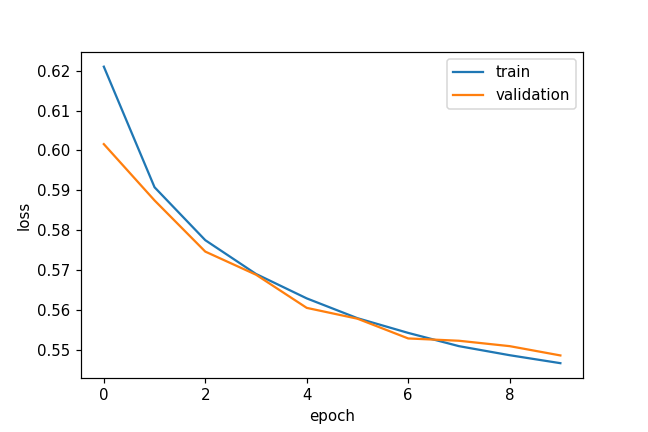

In [9]:
plotVsEpoch(history, 'loss')

<IPython.core.display.Javascript object>


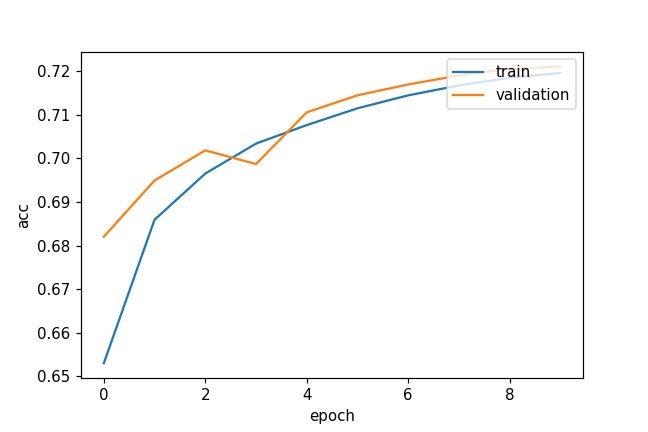

In [12]:
plotVsEpoch(history, 'acc')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2900      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>


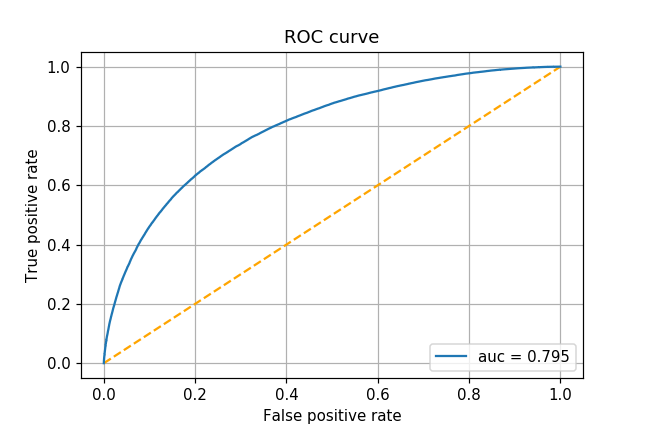

In [11]:
# apply model to get predictions on test set
y_pred = model.predict_proba(X_test)

#draw ROC
drawROC2(y_test, y_pred)

In [15]:
#do signal vs background plot
m_bb = X_test[:,25]

def isSignal(x, y):
    if (y>=0.5):
        return x
    else: 
        return -1.
    
def isBackground(x, y):
    if (y<0.5):
        return x
    else: 
        return -1.
isSignalNP = np.vectorize(isSignal)
isBackgroundNP = np.vectorize(isBackground)

m_bb_signal = isSignalNP(m_bb, y_test)
m_bb_background = isBackgroundNP(m_bb, y_test)
m_bb_signal_pred = isSignalNP(m_bb, y_pred[:,0])
m_bb_background_pred = isBackgroundNP(m_bb, y_pred[:,0])

<IPython.core.display.Javascript object>


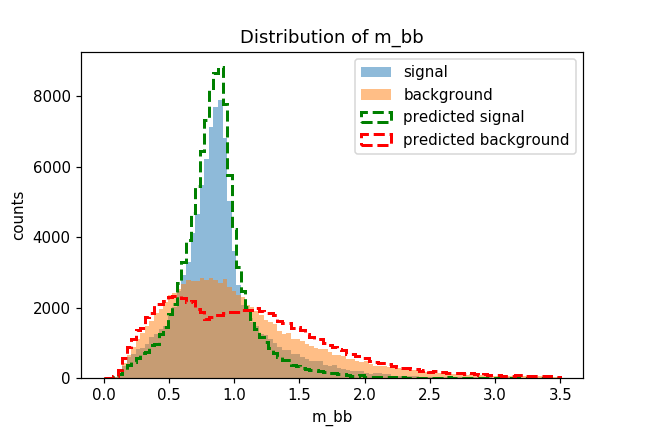

In [14]:
f, ax = plt.subplots()
plt.hist(m_bb_signal, bins = 100, range=[0, 3.5], alpha=0.5, label='signal') 
plt.hist(m_bb_background, bins = 100, range=[0, 3.5], alpha=0.5, label='background') 
plt.hist(m_bb_signal_pred, bins = 100, range=[0, 3.5], label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2) 
plt.hist(m_bb_background_pred, bins = 100, range=[0, 3.5], label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2) 
plt.title("histogram") 
ax.set_xlabel('m_bb')
ax.set_ylabel('counts')
ax.legend()
ax.set_title("Distribution of m_bb")
plt.show()
f.savefig("SignalvsBackgroundPred.pdf", bbox_inches='tight')

# Exercise 2

- play with the model parameters and see if you can improve the performances (try to add hidden layers)
- try to increase the number of epochs for training, is the model improving?
- how is training time affected by the number of parameters?
- how is signal versus background separation affected (check different variables)